Class that linearize and discretize a model arounf a point

In [ ]:
#import library
from sympy import symbols, IndexedBase, Idx
import sympy as sp
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
#from scipy.misc import derivative
from sympy import *

class DiscretizeandLinearizeGeneric():
  def __init__(self,Z,xhat,uhat,n):
    #matrix A of states linearize 
        self.Aj = np.zeros(shape= (x[n_states].shape[0],x[n_states].shape[0]))     
        #matrix B of input linearize
        self.Bj = np.zeros(shape= (x[n_states].shape[0],u[n_in].shape[0]))
        #point around that we will make the linearization 
        self.xhat = xhat[:]
        self.uhat = uhat[:]
        #equation of states (ODE)
        self.Z = Z
        #matrix of the difference between the real equation and the linearize one
        self.p = []
        #matrix of the discretize system
        self.Ad=[]
        self.Bd=[]
        self.Cd=[]
        #list of matrix discrete to make the convex opt
        self.Ad_list = [None]*(n-1)
        self.Bd_list = [None]*(n-1)
        self.Cd_list = [None]*(n-1)

  def evaluatePerte(self):
      dxdt = self.Z[:]
      #linearize the A matrix with symbols
      xhat = self.xhat
      uhat = self.uhat
      #evaluate the real system around the point xhat,uhat
      for c in range(len(dxdt)):
        for i in range(len(xhat)):
            dxdt[c] = dxdt[c].subs(x[i],xhat[i])
        for i in range(len(uhat)):
            dxdt[c]= dxdt[c].subs(u[i],uhat[i])
      #save the result inside a matrix
      #p will be the waste of the linearize system
      self.p = -self.p + dxdt[:]

      #class that calculate the matrix A and B jacobien and make the evaluation around the points xhat and uhat 
  def JacobianAndEvaluate(self):
      dxdt = self.Z[:]
      #linearize the A matrix with symbols
      xhat = self.xhat
      uhat = self.uhat
      #linearize the A matrix with symbols
      for c in range (len(dxdt)):
        for h in range (x[n_states].shape[0]):
          #calculate the derivative of the c ode of the x[h] variable of states
          A = sp.diff(dxdt[c],x[h])
          for i in range(len(xhat)):
            A = A.subs(x[i],xhat[i])
          for i in range(len(uhat)):
            A = A.subs(u[i],uhat[i])
          self.Aj[c][h] = A
      #self.Aj = np.array([[sp.diff(dx1dt,x[0]),sp.diff(dx1dt,x[1]),sp.diff(dx1dt,x[2])],[sp.diff(dx2dt,x[0]),sp.diff(dx2dt,x[1]),sp.diff(dx2dt,x[2])],[sp.diff(dx3dt,x[0]),sp.diff(dx3dt,x[1]),sp.diff(dx3dt,x[2])]])
      #linearize B matrix with symbols
      for c in range (len(dxdt)):
        for h in range (u[n_in].shape[0]):
          #calculate the B matrix making the derivative of ode respect to the inputs
          B = sp.diff(dxdt[c],u[h])
          for i in range(len(xhat)):
            B = B.subs(x[i],xhat[i])
          for i in range(len(uhat)):
            B = B.subs(u[i],uhat[i])
          self.Bj[c][h] = B
      #self.Bj = np.array([[sp.diff(dx1dt,u[0]),sp.diff(dx1dt,u[1])],[sp.diff(dx2dt,u[0]),sp.diff(dx2dt,u[1])],[sp.diff(dx3dt,u[0]),sp.diff(dx3dt,u[1])]])
      #print(self.Bj)
      #pass the information of the evaluation of the equation to evaluate the waste between the linear and non linear system
      self.p = np.dot(self.Bj,uhat) + np.dot(self.Aj,xhat)
      self.evaluatePerte()

  def mod_point(self,xhat,uhat):
    #calculate the matrix of the system to make the discretization 
        self.xhat = xhat[:]
        self.uhat = uhat[:]
        self.JacobianAndEvaluate()
  
  def lin2disc(self,xhat,uhat,n,dt):
        #discretize the system 
        self.mod_point(xhat,uhat)
        resolution = 100
        Adx_list = [None] * (resolution+1)
        Adr_list = [None] * (resolution+1)
        Adx_list[0] = np.eye(x[n_states].shape[0])
        Adr_list[0] = np.eye(x[n_states].shape[0])
        delta=dt/resolution
        for i in range(resolution):
          Adx_list[i+1] = Adx_list[i] + np.dot(Adx_list[i],self.Aj)*delta
          Adr_list[i+1] = Adr_list[i] - np.dot(Adr_list[i],self.Aj)*delta
        self.Ad = Adx_list[resolution]
        self.Bd = np.zeros([x[n_states].shape[0],u[n_in].shape[0]])
        self.Cd = np.zeros([x[n_states].shape[0],])
        #self.p = np.reshape(self.p,(3,1))
        #print(self.p)
        for i in range(resolution):
          Ard = Adr_list[i+1]
          self.Bd = self.Bd + (np.dot(Ard,self.Bj)*delta)
          self.Cd = self.Cd + (np.dot(Ard,self.p)*delta)
        self.Bd = np.dot(self.Ad,self.Bd)
        self.Cd = np.dot(self.Ad,self.Cd)
        #print(self.Ad)
        #print(self.Bd)
        #print(self.Cd)
        return self.Ad,self.Bd,self.Cd


  def disc(self,uw,n,dt,x_ss):
    #evaluate the system discrete 
      tf = dt*n 
      t = np.linspace(0,tf,n)
        # store solution
      xk = np.zeros(shape =(x[n_states].shape[0],n))
      # record initial conditions
      xk[:,0] = x_ss
      for i in range(1,n):
          u0 = uw[:,i-1]
          x0 = xk[:,i-1]
          #calculate the discrete matrix around the points x0 and u0
          self.Ad_list[i-1],self.Bd_list[i-1],self.Cd_list[i-1] = self.lin2disc(x0,u0,n,dt)
          #store solutions
          xk[:,i] = np.dot(self.Ad,x0)+np.dot(self.Bd,u0) + self.Cd 
      return xk 
      
  def get_list(self):
    return np.array(self.Ad_list).astype(np.float64),np.array(self.Bd_list).astype(np.float64),np.array(self.Cd_list).astype(np.float64)



Class that provide the calculation of CVX method to generate a trajectory


TRY TO create an obstacle to be avoided at 0.5 , 0.5 but not working with linear or quadratic constrains

In [ ]:
# Import packages.
import cvxpy as cp
import numpy as np

class ConvexOpt():
  def __init__(self,N,x_init,x_fin,u_in,A_list,B_list,C_list):
    #init the variables of the class
    self.N = N
    self.x_init = x_init
    self.x_fin = x_fin
    self.u_in = u_in
    self.Ad_list = A_list
    self.Bd_list = B_list
    self.Cd_list = C_list
    
  def CVXOPT(self,opt_power = False,opt_velocity = False):
    #save the number of states and inputs
    x_len =(int) (x[n_states].shape[0])
    u_len = (int) (u[n_in].shape[0])
    #define the variables to be evaluate 
    xv = cp.Variable(shape=(x_len, self.N))
    uv = cp.Variable((u_len, self.N-1))
    tau = cp.Variable(shape=(self.N))
    tau_vel = cp.Variable(shape=(self.N))
    tau_u = cp.Variable(shape=(self.N-1))
    hogb = cp.Variable(self.N-1)
    hog = cp.Variable(shape = (x_len,self.N-1))

    #define the objective of the convex optimization 
    obj = cp.sum_squares(np.ones(shape=(1,self.N))*tau +np.ones(shape=(1,self.N))*tau_vel + 10*np.ones(shape=(1,self.N-1))*tau_u  + np.ones(shape=(1,self.N-1))*10**3*hogb)
    obj = cp.Minimize(obj)
    #define all constrains to be take into account but they have to be convex 
    constr = []
    #initial condition for x-y position and angular position
    constr += [xv[:,0] == self.x_init]
    #initial condition related to inputs 
    constr += [uv[:,0] == self.u_in]
    #final position constrain 
    constr += [cp.norm(xv[:,self.N-1] - self.x_fin) <= 10e-9]
    #trajectory limitation 
    for t in range(0,self.N-1):
      #discrete trajectory with virtual control 
        constr += [ xv[:,t+1] == self.Ad_list[t]*xv[:,t] + self.Bd_list[t] * uv[:,t] + self.Cd_list[t]]
        #norm(hog(:,k)) <= hogb(k)
        constr += [cp.norm(hog[:,t]) <= hogb[t]]

    #take into account only the shortest trajectory 
        constr += [cp.norm(xv[:,t-1] - xv[:,t]) <= tau[t]]

        #I tried to code linear obstacle but  working only in rectangular case  
        #constr += [xv[1,t] <= 6]
        #constr += [xv[1,t] >= 0]
        #constr += [xv[0,t] <= 5] 
        #constr += [cp.norm2(xv[0,t] - 1) >= 1]
    #limit the final velocity    
    constr += [cp.norm(uv[:,self.N-2]) <= 10e-9]
    #contrain of the velocity of convergence to the final point % ||target - x_k||_2 <= taui_k
    if(opt_velocity):
      for t in range (0,self.N-1):
        constr += [cp.norm2(xv[:,t] - self.x_fin)<= tau_vel[t]]
    #constrain to optimize the power efficency related to the norm of u
    if(opt_power):
      for t in range (0,self.N-2):
        constr += [cp.norm(uv[:,t]) <= tau_u[t]]

    #resolve the problem    
    prob = cp.Problem(obj , constr)
    prob.solve(verbose=True)
    xv = np.array(xv.value)
    uv = np.array(uv.value)
    return xv,uv

LEt' s combine the two classes


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.447e-23  -1.940e-02  +3e+03  4e-01  2e-01  1e+00  1e+01    ---    ---    1  1  - |  -  - 
 1  +1.310e+00  +1.983e+00  +1e+03  3e-03  7e-02  1e+00  4e+00  0.7305  7e-02   1  2  2 |  0  0
 2  +1.132e+01  +1.408e+01  +7e+02  3e-03  8e-02  3e+00  3e+00  0.5801  5e-01   1  1  1 |  0  0
 3  +2.208e+01  +2.484e+01  +4e+02  2e-03  6e-02  3e+00  2e+00  0.5033  1e-01   1  1  1 |  0  0
 4  +2.776e+01  +3.211e+01  +3e+02  2e-03  7e-02  5e+00  1e+00  0.3350  4e-01   1  1  1 |  0  0
 5  +3.876e+02  +4.120e+02  +6e+01  2e-03  6e-02  2e+01  2e-01  0.8971  9e-02   1  2  1 |  0  0
 6  +2.548e+02  +2.752e+02  +2e+01  1e-03  5e-02  2e+01  1e-01  0.6492  9e-02   2  2  1 |  0  0
 7  +1.794e+01  +4.030e+01  +9e+00  4e-04  3e-02  2e+01  4e-02  0.9890  4e-01   2  2  2 |  0  0
 8  +4.703e-01  +1.071e+00  +2e-01  1e-05  9e-

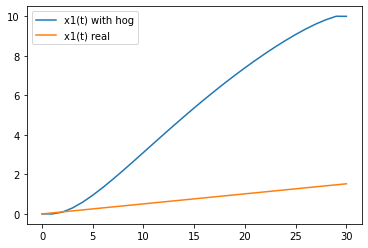

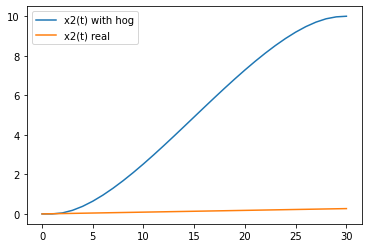

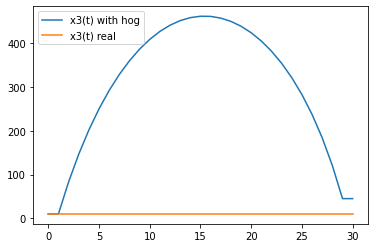

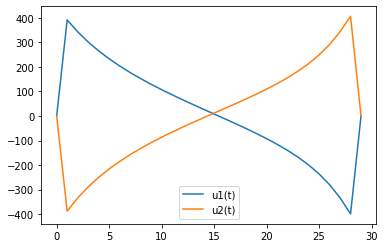


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.447e-23  -1.940e-02  +4e+03  4e-01  2e-01  1e+00  2e+01    ---    ---    1  1  - |  -  - 
 1  +1.854e+01  +2.344e+01  +2e+03  8e-03  2e-01  6e+00  8e+00  0.7219  3e-01   1  2  1 |  0  0
 2  +7.684e+01  +8.278e+01  +6e+02  3e-03  9e-02  6e+00  3e+00  0.7679  1e-01   1  3  1 |  0  0
 3  +6.129e+00  +1.362e+01  +2e+02  1e-03  6e-02  8e+00  9e-01  0.9890  4e-01   2  2  1 |  0  0
 4  -1.256e-01  +1.840e-01  +1e+01  4e-05  2e-03  3e-01  4e-02  0.9653  7e-03   1  1  1 |  0  0
 5  -1.674e-02  -1.370e-02  +2e-01  7e-07  4e-05  3e-03  7e-04  0.9839  1e-04   1  1  1 |  0  0
 6  -1.617e-04  -1.248e-04  +2e-03  8e-09  4e-07  4e-05  8e-06  0.9890  1e-04   2  1  1 |  0  0
 7  -1.808e-06  -1.396e-06  +2e-05  9e-11  5e-09  4e-07  9e-08  0.9890  1e-04   2  1  1 |  0  0
 8  -2.103e-08  -1.643e-08  +2e-07  1e-12  5e-

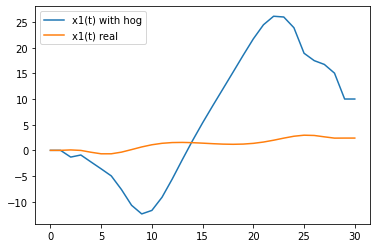

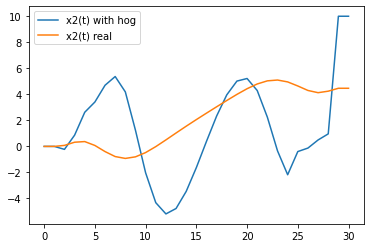

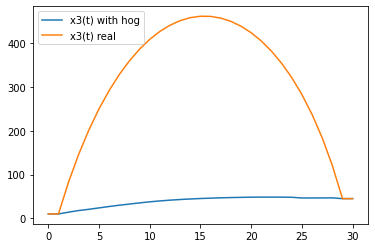

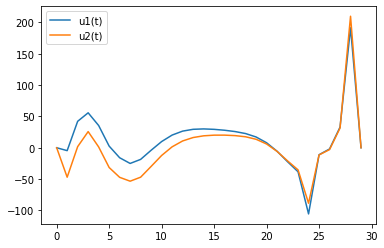


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.447e-23  -1.940e-02  +3e+03  4e-01  2e-01  1e+00  1e+01    ---    ---    1  1  - |  -  - 
 1  +1.163e+00  +1.773e+00  +1e+03  2e-03  6e-02  9e-01  4e+00  0.7415  6e-02   1  1  2 |  0  0
 2  +3.005e+00  +4.741e+00  +4e+02  1e-03  4e-02  2e+00  1e+00  0.8700  3e-01   1  2  2 |  0  0
 3  -1.252e+00  +8.000e-01  +1e+02  5e-04  3e-02  2e+00  6e-01  0.8712  3e-01   1  1  2 |  0  0
 4  -3.970e-02  +1.561e-02  +4e+00  1e-05  7e-04  6e-02  2e-02  0.9762  2e-03   1  1  1 |  0  0
 5  -4.541e-03  -4.007e-03  +7e-02  2e-07  1e-05  6e-04  3e-04  0.9841  1e-04   1  1  1 |  0  0
 6  -4.769e-05  -4.143e-05  +8e-04  2e-09  1e-07  7e-06  3e-06  0.9890  1e-04   2  1  1 |  0  0
 7  -5.356e-07  -4.656e-07  +9e-06  3e-11  1e-09  7e-08  4e-08  0.9890  1e-04   3  2  2 |  0  0
 8  -7.746e-09  -6.964e-09  +1e-07  3e-13  2e-

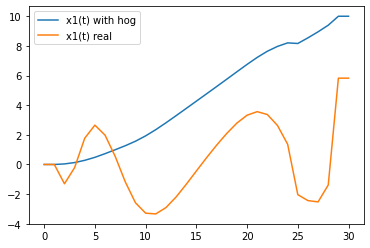

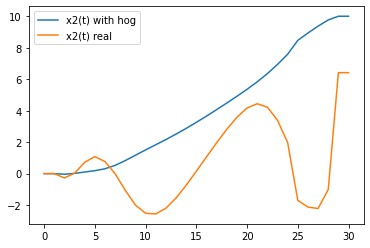

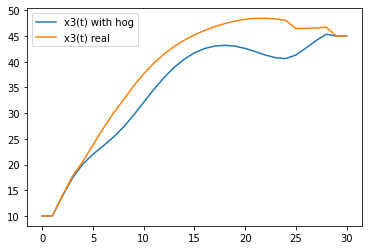

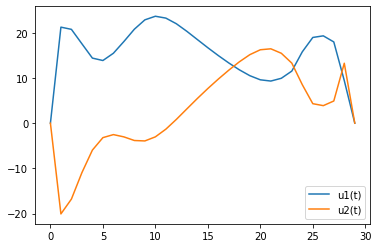


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.447e-23  -1.940e-02  +3e+03  4e-01  2e-01  1e+00  1e+01    ---    ---    1  1  - |  -  - 
 1  +1.160e+00  +1.769e+00  +1e+03  2e-03  6e-02  9e-01  4e+00  0.7411  6e-02   1  2  2 |  0  0
 2  +3.387e+00  +5.259e+00  +4e+02  1e-03  4e-02  2e+00  1e+00  0.8759  3e-01   1  2  2 |  0  0
 3  -1.156e+00  +1.440e+00  +2e+02  8e-04  4e-02  3e+00  8e-01  0.7280  4e-01   1  2  2 |  0  0
 4  -3.040e-02  +1.244e-01  +1e+01  4e-05  2e-03  2e-01  5e-02  0.9479  3e-03   1  2  1 |  0  0
 5  -1.310e-02  -1.160e-02  +2e-01  7e-07  3e-05  2e-03  8e-04  0.9842  1e-04   1  1  1 |  0  0
 6  -1.284e-04  -1.103e-04  +2e-03  7e-09  4e-07  2e-05  9e-06  0.9890  1e-04   2  1  1 |  0  0
 7  -1.439e-06  -1.237e-06  +2e-05  8e-11  4e-09  2e-07  1e-07  0.9890  1e-04   3  3  3 |  0  0
 8  -1.713e-08  -1.487e-08  +3e-07  9e-13  5e-

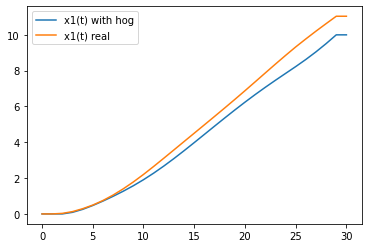

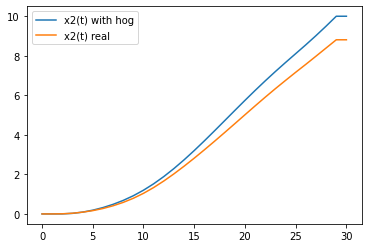

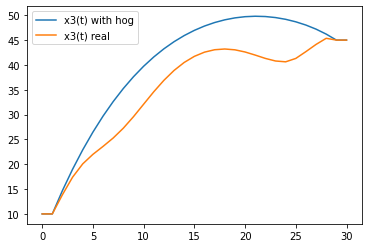

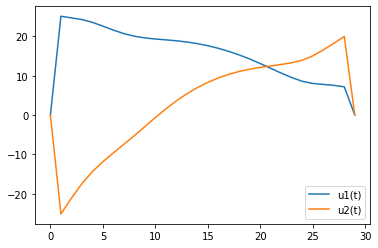


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.447e-23  -1.940e-02  +3e+03  4e-01  2e-01  1e+00  1e+01    ---    ---    1  1  - |  -  - 
 1  +1.179e+00  +1.797e+00  +1e+03  2e-03  7e-02  9e-01  4e+00  0.7403  6e-02   1  1  2 |  0  0
 2  +3.536e+00  +5.460e+00  +4e+02  1e-03  4e-02  2e+00  1e+00  0.8769  3e-01   1  1  1 |  0  0
 3  -1.296e+00  +1.444e+00  +2e+02  8e-04  4e-02  3e+00  9e-01  0.7192  4e-01   1  1  2 |  0  0
 4  -2.470e-02  +1.433e-01  +1e+01  4e-05  2e-03  2e-01  5e-02  0.9522  5e-03   1  2  2 |  0  0
 5  -1.345e-02  -1.182e-02  +2e-01  7e-07  4e-05  2e-03  8e-04  0.9841  1e-04   1  1  1 |  0  0
 6  -1.321e-04  -1.125e-04  +2e-03  7e-09  4e-07  2e-05  9e-06  0.9890  1e-04   2  1  1 |  0  0
 7  -1.480e-06  -1.261e-06  +2e-05  8e-11  4e-09  2e-07  1e-07  0.9890  1e-04   3  3  3 |  0  0
 8  -1.768e-08  -1.523e-08  +3e-07  9e-13  5e-

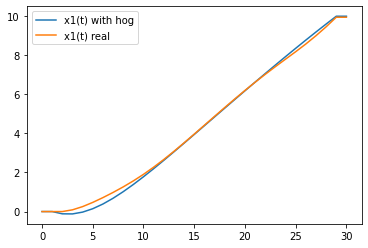

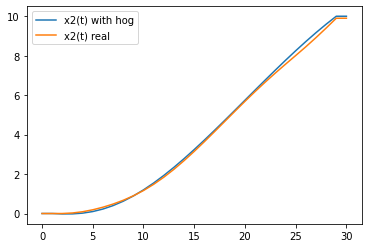

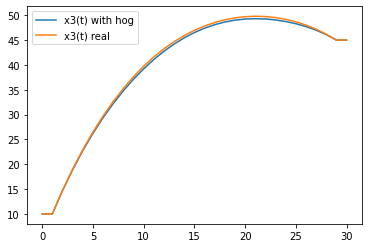

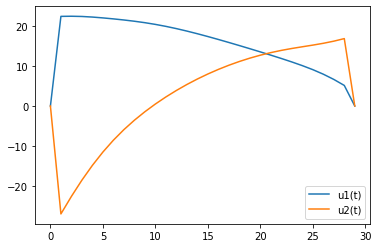


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.447e-23  -1.940e-02  +3e+03  4e-01  2e-01  1e+00  1e+01    ---    ---    1  1  - |  -  - 
 1  +1.182e+00  +1.800e+00  +1e+03  2e-03  7e-02  9e-01  4e+00  0.7402  6e-02   1  2  2 |  0  0
 2  +3.577e+00  +5.514e+00  +4e+02  1e-03  4e-02  2e+00  1e+00  0.8776  3e-01   1  2  1 |  0  0
 3  -1.349e+00  +1.439e+00  +2e+02  8e-04  4e-02  3e+00  9e-01  0.7144  4e-01   1  2  1 |  0  0
 4  -2.351e-02  +1.530e-01  +1e+01  4e-05  2e-03  2e-01  5e-02  0.9531  6e-03   1  2  2 |  0  0
 5  -1.372e-02  -1.201e-02  +2e-01  7e-07  4e-05  2e-03  8e-04  0.9842  1e-04   1  1  1 |  0  0
 6  -1.346e-04  -1.140e-04  +2e-03  8e-09  4e-07  2e-05  9e-06  0.9890  1e-04   2  1  1 |  0  0
 7  -1.508e-06  -1.278e-06  +3e-05  8e-11  4e-09  2e-07  1e-07  0.9890  1e-04   3  3  3 |  0  0
 8  -1.799e-08  -1.541e-08  +3e-07  9e-13  5e-

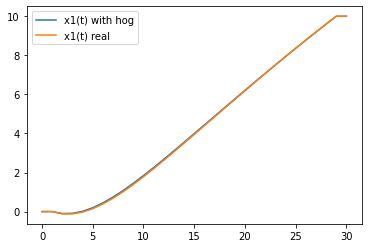

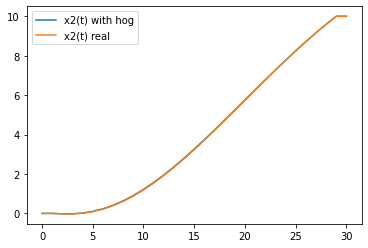

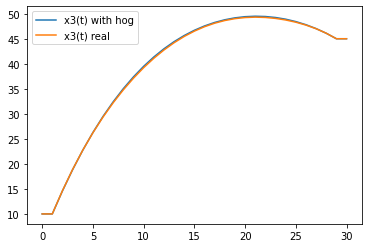

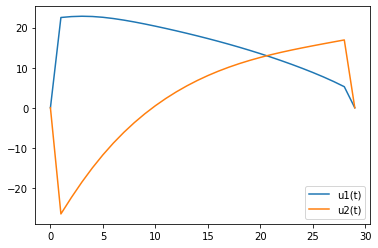

Real trajectory with calculated u signal


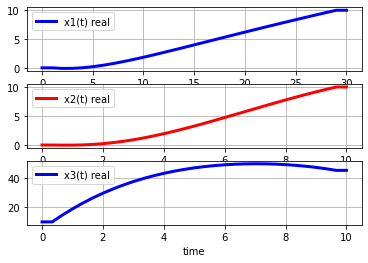

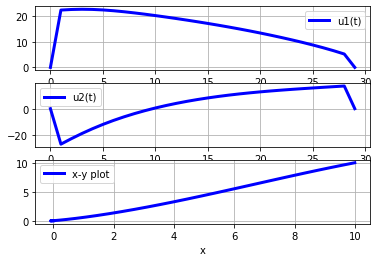

time passed to calculate the trajectory [seconds]:=
19.5888729095459
time disc:=
12.269347906112671
time cvx:=
3.471198558807373


In [ ]:
from sympy import symbols, IndexedBase, Idx
import sympy as sp
import numpy as np
import time 
from sympy import *
import matplotlib.patches as pat

#let's define the variables of the class (u inputs and x states)
u = IndexedBase('u')
n_in = symbols('n_in ', integer=True)
u[n_in]
#you can change the number of input but not the name
n_in = Idx('n_in', 2)
x = IndexedBase('x')
n_states = symbols('n_states', integer=True)
x[n_states]
#You can change the number of states not the name
n_states = Idx('n_states', 3)

# steady state conditions
x_init = [0,0,10]
u_ss = [1,1]
# final time
tf = 10 #(seconds)
#resolution
k = 3
# number of time points
n = tf * k + 1      #total points
# time points
dt = tf/n
t = np.linspace(0,tf,n)

#define the ode of the system
Z = [(.16/2)*(u[0]+u[1])*sp.cos((3.14/180)*x[2]),(.16/2)*(u[0]+u[1])*sp.sin((3.14/180)*x[2]),(.16/.55)*(u[0]-u[1])]
eq = DiscretizeandLinearizeGeneric(Z,np.zeros(x[n_states].shape[0]),np.ones(u[n_in].shape[0]),n)

# define inputs over time 
u1= np.ones(n) * u_ss[0]
u2= np.ones(n) * u_ss[1]
uw = np.array( [u1,u2])
#define the goal  position and the condition initial of the velocity
x_fin = [10,10,45]
u_in = [0,0]
#set the start time 
start = time.time()
# Some times to record each part
time_disc = 0
time_cvx = 0
x_len = len(x_init)
#iteration to find the optimum result
for i in range (6):
  st = time.time ()
  #resolution discrete sistem
  x1,x2,x3 = eq.disc(uw,n,dt,x_init)
  Ad_list,Bd_list,Cd_list = eq.get_list()
  time_disc += (time.time () - st) 
  #call the Convex optimization class to resolve the problem 
  st = time.time ()
  cvx = ConvexOpt(n,x_init,x_fin,u_in,Ad_list,Bd_list,Cd_list)
  #tell to optimize the power 
  opt_pow = True
  #tell to optimize the rapidity of convergence
  opt_conv = True
  xout,uout = cvx.CVXOPT(opt_pow,opt_conv)
  uw = uout
  time_cvx += (time.time () - st) 
  #plot the results 
  print("Results of the convexification number :",i+1)
  plt.plot(xout[0],label='x1(t) with hog')
  plt.plot(x1,label='x1(t) real')
  plt.legend(loc='best')
  plt.show()
  plt.plot(xout[1],label='x2(t) with hog')
  plt.plot(x2,label='x2(t) real')
  plt.legend(loc='best')
  plt.show()
  plt.plot(xout[2],label='x3(t) with hog')
  plt.plot(x3,label='x3(t) real')
  plt.legend(loc='best')
  plt.show()
  plt.plot(uw[0],label='u1(t)')
  plt.plot(uw[1],label='u2(t)')
  plt.legend(loc='best')
  plt.show()
  #obstacle affiche 

done = time.time()
#plot the true trajectory calculated take into account the estimated u vector with cvx optimization
x1,x2,x3 = eq.disc(uw,n,dt,x_init)
print("Real trajectory with calculated u signal")
plt.figure(1)
plt.subplot(3,1,1)
plt.plot(x1,'b-',linewidth=3,label='x1(t) real')
plt.xlabel('time')
plt.grid()
plt.legend(loc='best')
plt.subplot(3,1,2)
plt.plot(t,x2,'r-',linewidth=3,label='x2(t) real')
plt.xlabel('time')
plt.legend(loc='best')
plt.grid()
plt.subplot(3,1,3)
plt.plot(t,x3,'b-',linewidth=3,label='x3(t) real')
plt.xlabel('time')
plt.grid()
plt.legend(loc='best')
plt.show()

plt.subplot(3,1,1)
plt.plot(uw[0],'b-',linewidth=3,label='u1(t)')
plt.xlabel('time')
plt.grid()
plt.legend(loc='best')
plt.subplot(3,1,2)
plt.plot(uw[1],'b-',linewidth=3,label='u2(t)')
plt.xlabel('time')
plt.grid()
plt.legend(loc='best')
plt.subplot(3,1,3)
plt.plot(x1,x2,'b-',linewidth=3,label='x-y plot')
plt.xlabel('x')
plt.grid()
plt.legend(loc='best')
plt.show()
print("time passed to calculate the trajectory [seconds]:=")
elapsed = done - start
print(elapsed)
print("time disc:=")
print(time_disc)
print("time cvx:=")
print(time_cvx)


We can see that now for trajectory that are easy to be implemented the path calculated will be precisly the one followed by the model.
In the case that the trajectory is not so easy to be implemented we have to understand why.

CONSIDERATIONS:
it' s really important to understand why the trajectory calculated would not be precisly the one that we expected.
Firstly we have to consider that we are managing an approximation of the system so that we expect that in reality it will work even worst.
Secondly we have to take into account the resolution of our system, we have a resolution setted to 1 so we will calculate only one point per second and our velocity will change very slowly.
Due to this the system will response very slowly and our car cannot manage all the trajectory.
If we increase the number of point we have to deal with time issue.
It can be verify that if we increase the number of points the trajectory will be calculated after second and could be not useful for our application.
We have a trade-off between velocity and accuracy.

I don't  introduce a constraint to limite the value of the velocity because I suppose that inside the robot It will be present a PID controller that limit the range of the inputs.
To provide that limit in the case that we have to do so we can add this constrain to the class of CVXOPT that is just up.
